In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
from hdbscan import HDBSCAN
import spacy
pd.options.display.max_colwidth = 500

In [2]:
%%time
data = pd.read_csv('proc_17_108_unique_comments_text_dupe_count.csv')
print(f"Loaded in {len(data)} entries aggregating {data['dupe_count'].sum()} total comments.")

Loaded in 2955186 entries aggregating 22078910.0 total comments.
CPU times: user 22.7 s, sys: 4.79 s, total: 27.5 s
Wall time: 27.9 s


In [3]:
nlp = None
try:
    nlp = spacy.load("en", tagger=False, entity=False, matcher=False, parser=False)
except:
    import en_core_web_md
    nlp = en_core_web_md.load(tagger=False, entity=False, matcher=False, parser=False)

In [4]:
#take a sample to vectorize and cluster with dbscan
sample_size = 10000 # can play with this - starts to get unmanageable on my desktop @ sample_size > 100000
data_sample = data.sample(sample_size, random_state=42)

In [5]:
def encode_doc_vecs(docs):
    #encode mean word vector per document - might take a while
    #it took about 10s per 10,000 documents on my desktop
    #would want to parallelize this for a large enough job
    doc_vecs = []
    for doc in docs:
        #encode the doc if it is a string
        if type(doc) == str:
            doc_spaced = nlp(doc)
            doc_vec = np.mean([word.vector for word in doc_spaced], axis=0)
            #in case the doc vector could not be encoded, e.g., empty string, no words found
            if type(doc_vec) != np.ndarray or doc_vec.shape[0] != 300:
                print(f"Not Vectorizable: {doc}")
                doc_vec = np.zeros(300)
        else:
            print(f"Not a String: {doc}")
            doc_vec = np.zeros(300)
        doc_vecs.append(doc_vec)
    return doc_vecs

In [6]:
%%time
doc_vecs = encode_doc_vecs(data_sample['text_data'])

CPU times: user 7min 39s, sys: 56.1 s, total: 8min 35s
Wall time: 5min 18s


In [7]:
#use the euclidean distance of the l2-normalized vectors (angular distance), which is proportional to the cosine distance
norm_doc_vecs = normalize(doc_vecs, norm='l2')

In [8]:
# play with eps and metric
# higher eps will take *much* more time & resources
# clusterer = DBSCAN(eps=0.001, min_samples=5, n_jobs=-1, metric='cosine')

In [9]:
# can also try HAC - play with number of clusters, ward linkage seemed to give the best results generally
# clusterer = AgglomerativeClustering(n_clusters=20, linkage='average', affinity='cosine')
#clusterer = AgglomerativeClustering(n_clusters=60, linkage='ward')

In [10]:
# can also try HDBSCAN
clusterer = HDBSCAN(min_cluster_size=5)

In [11]:
%%time
labels = clusterer.fit_predict(norm_doc_vecs)

CPU times: user 43.7 s, sys: 108 ms, total: 43.8 s
Wall time: 43.9 s


In [12]:
X_clustered = pd.concat([pd.Series(data=labels, name='cluster'),data_sample.reset_index(drop=True),pd.DataFrame(doc_vecs)], axis=1)
# take a quick peek
X_clustered.sample(100)

,cluster,docid,text_data,dupe_count,0,1,2,3,4,5,...,290,291,292,293,294,295,296,297,298,299
2055,-1,2050356,Please maintain net neutrality as it stands. Thank you.,1.0,-0.113533,0.145995,-0.239002,-0.018118,0.011647,0.010563,...,-0.047100,0.001462,-0.056991,-0.106188,0.032229,-0.119108,0.095329,-0.093220,0.034711,0.094339
5579,10,3497745,"In the matter of Net neutrality. I strongly implore the commission to rescind Barack Obama's decision to take over broadband. Americans, as opposed to the FCC Enforcement Bureau, should be able to buy which services they prefer. Barack Obama's decision to take over broadband is a distortion of the open Internet. It stopped a free-market system that worked very well for two decades with both parties' support.",2.0,-0.048900,0.148260,-0.057198,-0.021527,0.024719,-0.025871,...,-0.167524,0.049778,0.005471,-0.087203,0.025988,-0.041016,0.041387,-0.068680,0.015098,0.135528
532,10,3284549,"To the Federal Communications Commission: I'm very concerned about Internet regulation. I implore Chairman Pai to reverse Tom Wheeler's decision to control the web. Internet users, rather than the FCC Enforcement Bureau, deserve to buy whichever products we desire. Tom Wheeler's decision to control the web is a betrayal of the open Internet. It stopped a pro-consumer approach that worked remarkably smoothly for a long time with Republican and Democrat backing.",1.0,-0.066770,0.150083,-0.094315,-0.050129,0.027743,0.021970,...,-0.172045,0.012340,0.047099,-0.005385,0.023159,-0.036783,0.060465,-0.061741,-0.041450,0.150273
7433,10,2916638,"Hi, I'd like to comment on network neutrality regulations. I'd like to ask Chairman Pai to repeal The previous administration's plan to take over Internet access. People like me, rather than the FCC, should be free to select the products they want. The previous administration's plan to take over Internet access is a perversion of net neutrality. It broke a market-based framework that functioned fabulously successfully for a long time with Republican and Democrat consensus.",1.0,-0.021256,0.113696,-0.136097,0.014450,-0.009111,0.003605,...,-0.138154,0.074805,0.020535,-0.030176,0.018772,-0.062264,0.009155,-0.078024,0.028235,0.177897
3060,-1,126757,I specifically support strong net neutrality backed by Title II oversight of the Internet Service Providers (ISP),3.0,-0.121619,0.031958,-0.127538,-0.040230,-0.020925,0.023514,...,-0.229924,-0.022880,-0.004083,-0.036996,0.035666,-0.022148,0.108820,-0.189882,0.001511,0.210885
6305,3,9917682,"I am in favor of strong net neutrality under Title II of the Telecommunications Act.\n\n\nSincerely,\nGeneva Jackson",118.0,-0.052714,0.144632,-0.123254,-0.051440,0.020243,0.070949,...,-0.085771,0.064923,-0.028977,-0.184300,0.070097,0.027210,0.060077,-0.063131,-0.059553,0.125325
8004,40,10107878,"The FCC's Open Internet Rules (net neutrality rules) are extremely important to me. I urge you to protect them.\n\nI don't want ISPs to have the power to block websites, slow them down, give some sites an advantage over others, or split the Internet into ""fast lanes"" for companies that pay and ""slow lanes"" for the rest.\n\nNow is not the time to let giant ISPs censor what we see and do online.\n\nCensorship by ISPs is a serious problem. Comcast has throttled Netflix, AT&T blocked FaceTime, T...",2.0,-0.061638,0.166877,-0.163322,-0.040341,0.065965,-0.015461,...,-0.266901,0.001465,0.014860,-0.014332,0.020890,-0.023739,0.015241,-0.078513,0.069334,0.144577
8448,10,2314026,"Chairman Pai: In the matter of the FCC regulations on the Internet. I strongly recommend the government to repeal The Obama/Wheeler policy to take over the web. Individual Americans, rather than the FCC Enforcement Bureau, should be empowered to purchase whatever services they choose. The Obama/Wheeler policy to take over the web is a betrayal of the open Internet. It stopped a free-market policy that performed very, very well for decades with Republican and Democrat support.",2.0,-0.040857,0.1011

In [13]:
# visualize silhouette scores (without outliers)
# our goal is to find the largest, densest clusters from which to manually pick out signature strings
from sklearn.metrics import silhouette_samples, silhouette_score

In [14]:
# we can focus on certain clusters using a mask, but it's not useful to plot the -1 outliers
# w/ caveat that changing the mask will artifically inflate your sil score
num_clusters_skipped = 0 # speed up by skipping the first few (huge) clusters; 
mask = list(range(num_clusters_skipped, X_clustered['cluster'].max() + 1)) #since count = max + 1; ignore outliers (-1)

In [15]:
X_masked = X_clustered[X_clustered['cluster'].isin(mask)]
features = X_masked.iloc[:,-300:]
cluster_labels = X_masked['cluster']

In [16]:
# Calculate silhouette scores - takes a while for if you don't mask out first few clusters
n_clusters = len(mask)

# Summary stat
silhouette_avg = silhouette_score(features, cluster_labels)
print(f"For the clusters examined, the average silhouette_score is {silhouette_avg}")

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(features, cluster_labels)

For the clusters examined, the average silhouette_score is 0.08326191993090572


/Users/jeffkao/Documents/ai-structured-prediction/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


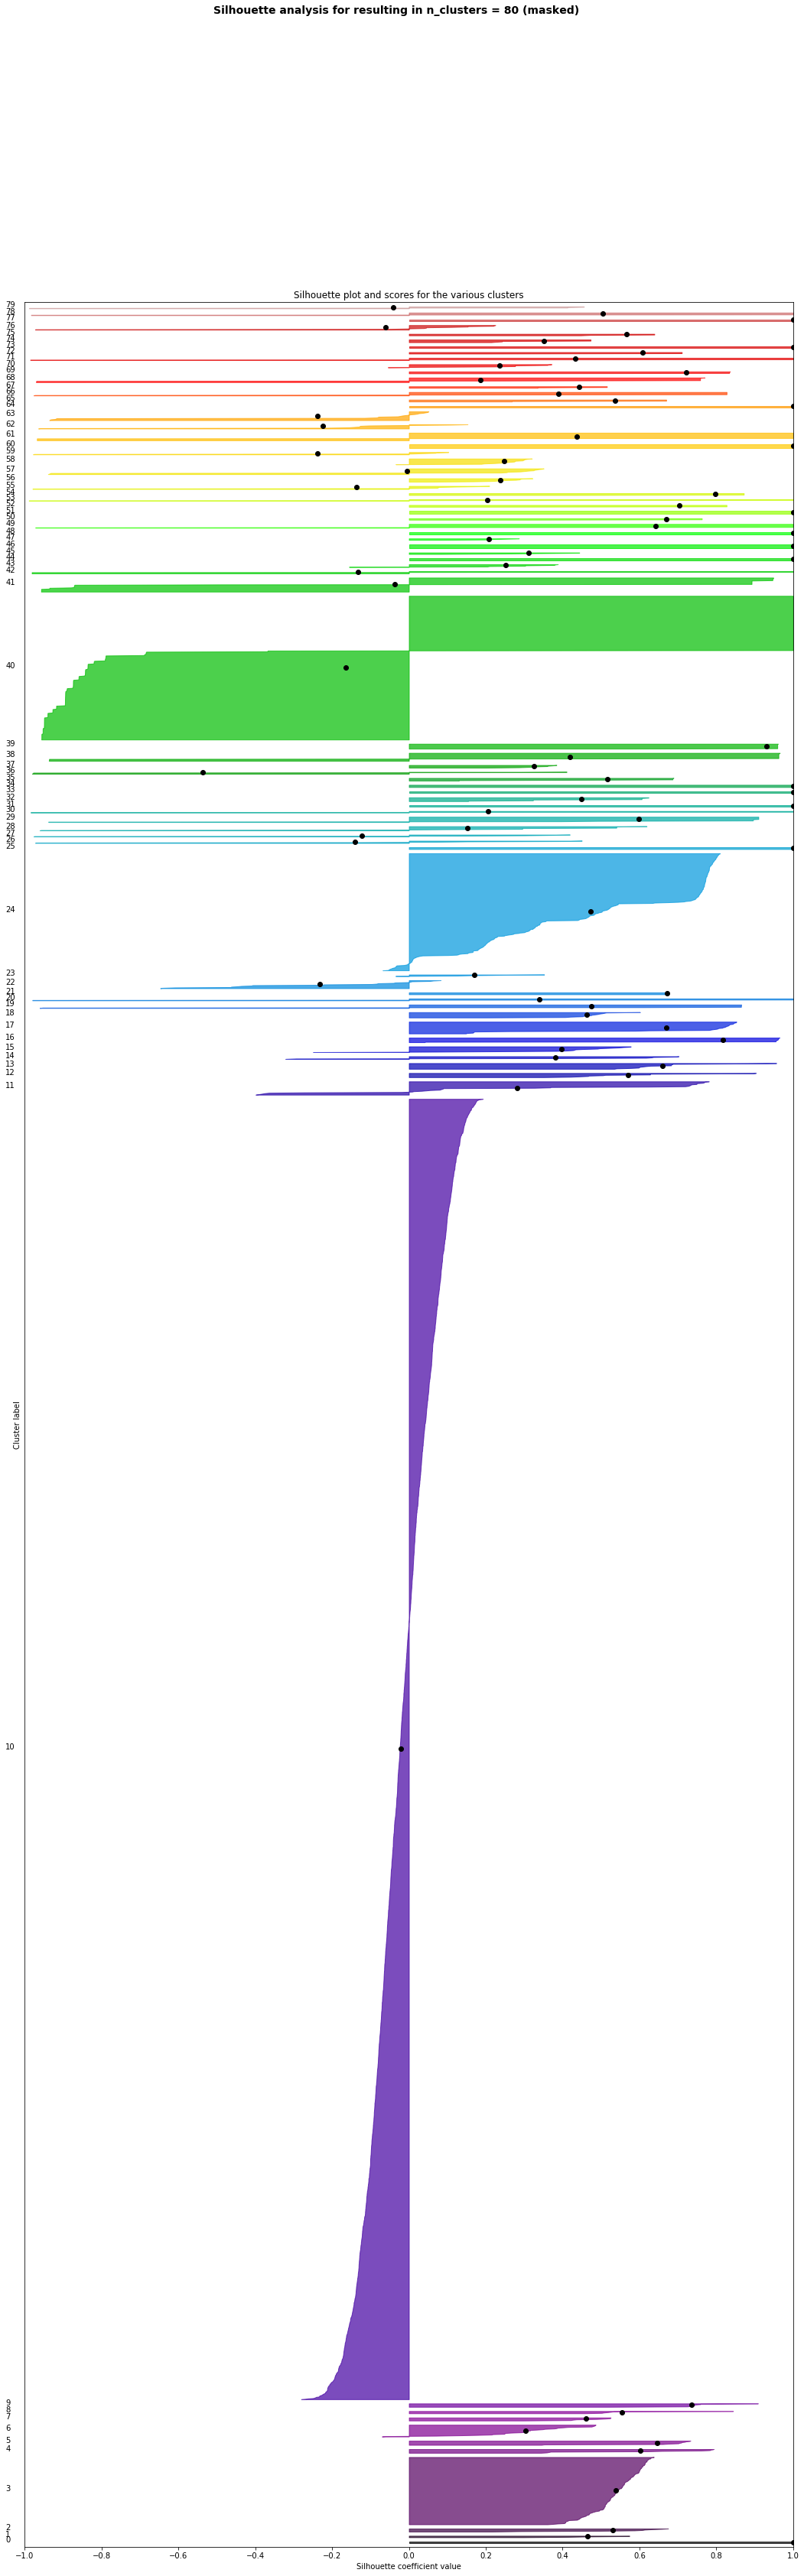

In [17]:
# Plot to get a sense of density and separation of the formed clusters
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Save the scores
X_masked['silhouette_score'] = sample_silhouette_values

fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 54)
ax1.set_autoscaley_on(True)

# xlim -> silhouette coefficient range (unlikely negative in our case)
ax1.set_xlim([-1.0, 1.0])
ax1.set_ylim([0, len(X_masked) + (n_clusters + 1) * 10])

y_lower = 10
for i in mask:
    # Aggregate and sort to get a profile for cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    # Draw
    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label
    ax1.text(-1.05, y_lower + 0.5 * size_cluster_i, str(i))

    # A dab at the average silhouette score for cluster i
    ax1.scatter(x=ith_cluster_silhouette_values.mean(), y=y_lower + 0.5 * size_cluster_i, color='k')
    
    # Compute the new y_lower for next cluster
    y_lower = y_upper + 10
    
ax1.set_title("Silhouette plot and scores for the various clusters")
ax1.set_xlabel("Silhouette coefficient value")
ax1.set_ylabel("Cluster label")
ax1.set_yticks([])  # clear
ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(f"Silhouette analysis for resulting in n_clusters = {n_clusters} (masked)",
             fontsize=14, fontweight='bold')

plt.show()

In [18]:
# poke around to make sure it looks reasonable
def examine_cluster(cluster_num, num_rows_listed=5):
    cluster_num = cluster_num #pick your cluster - the triangular ones are the mad-libs
    cluster_to_check = X_masked[X_masked['cluster'] == cluster_num][['silhouette_score','text_data']].sort_values('silhouette_score')
    print(f'== TOP {num_rows_listed} SILHOUETTE SCORES ==')
    print(cluster_to_check.tail(5))
    print(f'\n== BOTTOM {num_rows_listed} SILHOUETTE SCORES ==')
    print(cluster_to_check.head(5))

In [55]:
# example clusters: 2, 3, 5, 6, 10, 11
examine_cluster(10)

== TOP 5 SILHOUETTE SCORES ==
      silhouette_score  \
7510          0.176435   
200           0.179572   
2437          0.180443   
2364          0.184913   
1705          0.192486   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             text_data  
7510                                 FCC commissioners,  I am a voter worried about network neutrality regulations. I urge the commission to overturn Barack Obama's scheme to regulate Internet access. People like me, rather than the FCC, ought to select whatever applications we desire. Barack Obama's scheme to regulate Int